# Investigating Heat Transfer as a Function of Volume

In [1]:
# Configure Jupyter so figures appear in the notebook
%matplotlib inline

# Configure Jupyter to display the assigned value after an assignment
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'

# import functions from the modsim.py module
from modsim import *
import pandas as pd
from scipy import stats
import numpy as np

## Question
The phenomenon in question is a universal one - one that anyone who consumes hot beverages experiences on a regular occurrence: As a hot drink is being consumed, the liquid looses heat faster the less volume there is left. The resulting experience is a colder drink the faster it is consumed. Thus, we set out to answer the questions: 
1. How can the relationship between the water's change in volume and change in rate of temperature change be qualitatively explained?
2. Can we predict the final temperature of a fluid at a given time based on its starting temperature, the temperature of its environment, the heat transfer coefficient specific to its container, the dimensions of the container (a rectangular prism with a square base), and its rate of change of volume (assumed to be constant)?

# Model
To answer these questions, we start with $dTdt = -r * (T - T_e)$ where $T_e$ is the temperature of the environment, and $r$ is a constant that represents: $(h*A)/(C*m)$ where $h$ is the heat transfer coefficient, $A$ is the surface area of convection, $C$ is the specific heat of water, and $m$ is the mass of the water. Thus, $r$ can be represented as a function of the volume of water. Some assumptions are made in our model: 
1. The heat transfer is assumed to be constant over all surfaces of the container, which in the physical world isn't true: the heat transfer coefficient is different depending on whether the water is in contact with the air or with the walls of the container. Because the container we are modeling is a plastic container and therefore of low conductivity, we believe this is negligible. 
2. The dimensions of the container: because the dimensions of the container must be defined to avoid a two-dimensional function, we reference the container used in the later experiment: a 0.13m x 0.13m x 0.05m plastic container.
3. The heat transfer constant: because the heat transfer constant is an empirically determined value, we chose the value of `h = 0.09` to match our mathematical model as close as possible to our empirical model (seen later in the essay). 
While this is an empirically-driven mathematical model, these values must be measured to achieve a two-dimensional result. Thus, our results are constrained to interpretation only in the context of our specific container, but the model is flexible enough to accommodate any container so long as the empirical information is supplied.

The function that takes `V` as an argument and returns $r$ (`r`) is shown below:

In [2]:
# Function of r using math:
def r_math(V):

    if V > 0:
        # size of box:
        x = .13
        
        mass = V*0.001

        # heat transfer coefficient between air and water
        h = 0.09
        # heat capacity of water
        C = 4.184

        # surface area as a function of volume (volume in the equation is in kiloliters, so it
        # needs to be converted to milliliters)
        SA = 2*(x**2) + (4*(V* 0.000001))/x
    
    else:
        x = .13
        mass = .001
        h = 0.09
        C = 4.184
        SA = 2 * (x**2) + (4 * (V * 0.000001)) / x
    return ((h*SA)/(C*mass))

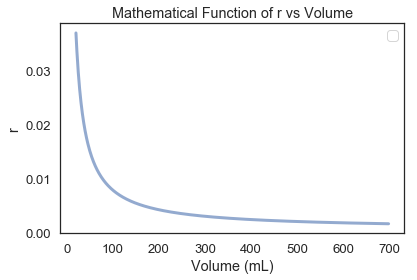

In [3]:
# Visualizing r_math:
listv = []
listr = []
for V in range(20, 700):
    listv.append(V)
    listr.append(r_math(V))
    
plot(listv, listr)
decorate(xlabel = 'Volume (mL)',
         ylabel = 'r',
         title = 'Mathematical Function of r vs Volume')

When using dTdt to update the temperature stock of the water, instead of passing in $r$ as a constant, it is passed in as `r_math` evaluated at the volume (`V`) at the given time step. The volume too doesn't remain constant because it is being swept; the volume is passed in by `dvdt`. 

In [4]:
def update_func(state, t, system, dvdt, r_math):
    """Update the thermal transfer model.
    
    State objects:
    Temperature of vessle
    Volume of vessle
    
    t --> time
    T --> Temperature
    
    returns: State object containing the stocks
    """
    unpack(system)
    
    T = state.T
    V = state.V
    
    r = r_math(state.V)
        
    dTdt = -r * (T - T_env)
    # dvdt is passed in as an argument - it is being swept. We truncate it to two decimal points.
    dvdt = round(dvdt, 2)

    if(V>0 and T >25):
        T += dTdt * dt
        V += dvdt * dt
    else:
        V = 0
        T = None
    return State(T=T, V=V)

In [5]:
def run_simulation(system, update_func, dvdt, r_math):
    """Runs a simulation of the system.
    
    Add a TimeFrame to the System: results
    """
    unpack(system)
    
    frame = TimeFrame(columns=init.index)
    frame.row[0] = init
    ts = linrange(0, t_end, dt)
    
    for t in ts:
        frame.row[t+dt] = update_func(frame.row[t], t, system, dvdt, r_math)
        
    # store the final temperature in T_final
    system.T_final = get_last_value(frame.T)
    
    return frame

In [6]:
def make_system(T_init, V_init, dvdt):
    """Makes a System object with the given parameters.

    T_init: initial temperature in degC
    r: heat transfer rate - when run, a function of r will be substituted in for it
    t_end: end time of simulation
    T_env: temperature of the environment
    dt: time step
    
    returns: System object
    """
    init = State(T=T_init, V=V_init)
    
    # T_final is used to store the final temperature.
    # Before the simulation runs, T_final = T_init
    # We do the same thing for Volume
    T_final = T_init
    V_final = V_init
    
    T_env = 25
    dt = 1
    
    # n_sweep stands for number of sweeps that the model will perform
    n_sweep = 9
    
    # n_sec stands for number of seconds that the simulation will be run for
    t_end = 600
    
    # Used at the end of this simulation, this is the threshold that determines
    # what rates of volume change over a given time period will result in a 
    # temperature at or over 40 degrees celcius.
    minimum_acceptable_temp = 40
    
    return System(locals())

system = make_system(85, 700, -1);

In [7]:
def sweepdVdt(system):
    sweep = SweepSeries()
    dvdt_range = linspace(-5,0,system.n_sweep)
    
    for t in range(0, system.n_sweep):
        dvdt = dvdt_range[t]
        sweep[t] = run_simulation(system, update_func, dvdt, r_math)

    return sweep

swept = sweepdVdt(system);

### Qualitative Result of Mathematical Model:

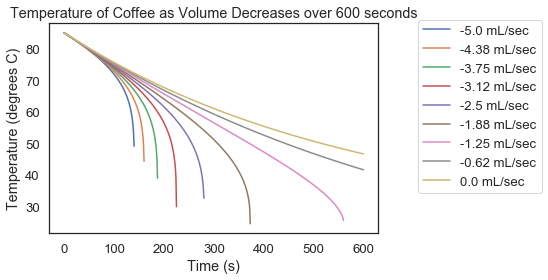

In [8]:
dvdt_range = linspace(-5,0,system.n_sweep)
fig = plt.figure()
ax = plt.subplot(111);
for i in range(system.n_sweep):
    dvdt = round(dvdt_range[i], 2)
    ax.plot(swept[i].index, swept[i].T, label = str(dvdt) + ' mL/sec')
    decorate(xlabel = 'Time (s)',
            ylabel = 'Temperature (degrees C)',
            title = 'Temperature of Coffee as Volume Decreases over {} seconds'.format(system.t_end))
    ax.legend(bbox_to_anchor=(1.1,1.05))

The qualitative result appears to validate our experiences with consuming hot liquids: the higher the rate of change of volume, the quicker the drop in temperature. However, because this is a mathematical model, when the volume is infinitely small, an infinite slope of temperature over time results. This is not something that is observed in the physical world, and is a shortcoming of the mathematical model.

### Quantitative Result of Mathematical Model
The final temperatures of each `dvdt` sweep are plotted below, along with a "Minimum Acceptable Temperature." The following code exists to extract those final temperatures, and the "Minimum Acceptable Temperature" represents an arbitrary threshold that can be set to determine what rates of change of volume will yield a desired temperature. It is important to note that the following results are specific to not only the container used for the experiment, but also the 600 second time frame that is modeled. 

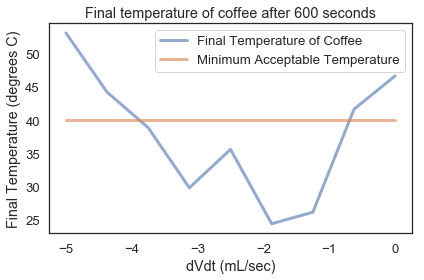

In [18]:
# Creating the time series in which the last temperatures from each dVdt sweep will be stored.
last_temp = TimeSeries()

def determine_last_temp(last_temp, system, swept):
    # Selecting the last values from each sweep by selecting the temperature associated with the point 
    # at which the volume first hits 0 mL. If the volume never reaches 0, the last temperature is still selected. 
    for i in range(system.n_sweep):
        for t in range(system.t_end):
            if (swept[i].V[t] == 0 or t == system.t_end - 1):
                last_temp[i] = swept[i].T[t-1]
                break
    return last_temp

last_temp = determine_last_temp(last_temp, system, swept)

# To plot the data against dVdt and not against the sweep numbers, the dvdt values and last temperature
# values will be converted into lists and then plotted against each other.
dvdt_list = []
last_temp_list = []

for i in range(len(dvdt_range)):
    dvdt_list.append(dvdt_range[i])
    last_temp_list.append(last_temp[i])

def plot_final_temp_and_minimum_acceptable_temp(dvdt_list, last_temp_list, minimum_acceptable_temp):
    plot(dvdt_list, last_temp_list, label = 'Final Temperature of Coffee')
    
    # The minimum acceptable temperature will be plotted as a line. To achieve this, a list of length 
    # len(dvdt_range) will created and contain the minimum acceptable temperature in each index. 
    minimum_acceptable_temp_list = list()
    for i in range(len(dvdt_range)):
        minimum_acceptable_temp_list.append(minimum_acceptable_temp)
    plot(dvdt_list, minimum_acceptable_temp_list, label = 'Minimum Acceptable Temperature')
    return minimum_acceptable_temp_list

plot_final_temp_and_minimum_acceptable_temp = plot_final_temp_and_minimum_acceptable_temp(dvdt_list, last_temp_list, 
                                                                                          minimum_acceptable_temp)
decorate(xlabel = 'dVdt (mL/sec)', 
         ylabel = 'Final Temperature (degrees C)', 
         title = 'Final temperature of coffee after {} seconds'.format(system.t_end))

This graph illustrates that, given enough parameters/information about a specific container, the final temperature can be predicted based on the rate of change of volume of the container. A minimum is expected to occur approximately dVdt = -2 because that indicates a cusp at which the container will either have zero or nonzero volume remaining (to the right and left of the cusp respectively). However, the graph is likely inaccurate because it exhibits an odd behavior: a local minimum and maximum occur between -4 < dVdt < -3. There is no reason to suggest that this phenomenon should occur, as the relationship between volume and r does not exhibit any inflection points. A likely explanation for this shortcoming are the infinite slopes that exist in the temperature vs. time graphs when volume approaches 0, which may result in inaccurate readings at the extremities of the graphs. This mathematical model will be further analyzed in comparison to the following empirical model.    

# Validation of Mathematical Model - Repeating  Model using Empirical Data

In order to empirically obtain a graph of the heat transfer coefficient as a function of volume, we obtained a series of empirically determined r values (specific to the container used in the experiments) at different volumes. Eleven different volumes in total were used, and to calculate the r value, the following procedure was used: 
1. Set up experiment: connect a thermistor to a breadboard such that it is the second resistor in the voltage
divider. The voltage divider must be connected to a 5V power supply and ground, and the first resistor must have a 
resistance of 1k-ohm. Measure the voltage drop across the voltage divider.  
2. Bring water to near-boiling temperature.
3. Pour water into container on a scale until the desired mass/volume of water is achieved
4. Insert the thermistor into the water.
5. Record the starting voltage, as well as the voltage after 5 minutes.
6. Convert the voltage to temperature using the following equation:
    T = (ln(5/Voltage - 1)/3528 + 1/298)^-1 - 273
7. Calculate an r value using the following equation:
    r = 1/t_end * log((T_init - T_env)/(T_end - T_env))
8. Repeat steps 2-7 for as many volumes are desired.

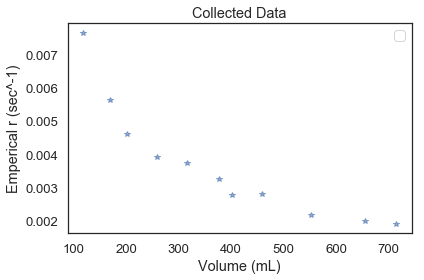

In [10]:
# A list of the data collected in our experiments. Each volume has a corresponding calculated r value
data = {'Volume': [118.354, 169.507,202.606,258.774,316.948,377.128,401.2,458.371,551.65,654.959,714.136,], 
             'r': [0.007660215,0.00563342,0.004614561,0.003912183,0.003744291,0.003259004,0.002769218,
                   0.002814454,0.002157224,0.001998175,0.001906878]}
# Creating a DataFrame from our collected data:
r_vs_volume_data = pd.DataFrame(data=data);

plot(r_vs_volume_data['Volume'], r_vs_volume_data['r'], '*')
decorate(xlabel = 'Volume (mL)', ylabel = 'Emperical r (sec^-1)', title = "Collected Data")

### Finding a curve of best fit for the data.

In [11]:
# In order to find a best fit curve, we first linearize the data in data2, then create r_vs_volume_transformed_data 
# as the DataFrame that contains the linearized data.
data2 = {'Volume': r_vs_volume_data['Volume'], 'Transformed r': 1 / r_vs_volume_data['r']}
r_vs_volume_transformed_data = pd.DataFrame(data=data2);

## Code for plotting the results of the above:

#plot(r_vs_volume_transformed_data['Volume'], r_vs_volume_transformed_data['Transformed r'], '*')
#decorate(xlabel = 'Volume (mL)', ylabel = 'Linearized r (sec)', title = "Experimental Data: Linearized r vs. Volume")

In [12]:
# Calculate a linear best fit line for the transformed data
x = r_vs_volume_transformed_data['Volume']
y = r_vs_volume_transformed_data['Transformed r']
slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)

#Create the line from calculated slope and intercept
def r_linear_function(slope, intercept, volume):
    r = slope * volume + intercept
    return r

## Code for plotting the results of the above:

#r_plot = r_linear_function(slope, intercept, r_vs_volume_transformed_data['Volume'])

#def plot_linear_on_data(r_plot):
#    plot(r_vs_volume_transformed_data['Volume'], r_vs_volume_transformed_data['Transformed r'], '*', label = "Data")
#    plot(r_vs_volume_transformed_data['Volume'], r_plot, label = "Line of Best Fit")
#    decorate(xlabel = 'Volume (mL)', ylabel = 'Linearized r', title = "Line of Best fit with Linearized Data")  
#plot_linear_on_data(r_plot)

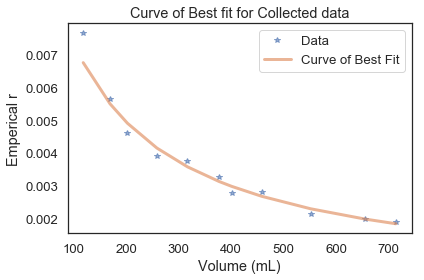

In [13]:
# De-linearizes the data and the line of best fit to give the best fit curve, returns the curve:
def unflipper(r_linear_function, slope, intercept, volume):
    r = r_linear_function(slope, intercept, volume) ** -1
    return r

r_nonlinear_function = unflipper(r_linear_function, slope, intercept, r_vs_volume_transformed_data['Volume'])

# Plots the curve of best fit with the data collected:
def plot_nonlinear_on_data(r_nonlinear_function):
    plot(r_vs_volume_data['Volume'], r_vs_volume_data['r'], '*', label = "Data")
    plot(r_vs_volume_data['Volume'], r_nonlinear_function, label = "Curve of Best Fit")
    decorate(xlabel = 'Volume (mL)', ylabel = 'Emperical r', title = 'Curve of Best fit for Collected data')

plot_nonlinear_on_data(r_nonlinear_function)

This curve closely resembles the mathematical one defined earlier, both in shape and in values - as it should, considering that the mathematical model was calibrated to match this function. 

### Qualitative Result of Empirical Model
Now, the simulation is run again with the empirically determined r as a function of volume replacing the mathematical one:

*Note: The code will be blocked into one cell because it is a identical repeat of the previously used code, with the exception of `unflipper` replacing `r_math` and adding in the additional function arguments as necessary.* 

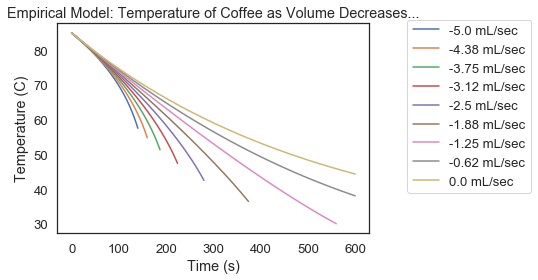

In [14]:
def update_func2(state, t, system, dvdt, unflipper, r_linear_function, slope, intercept):
    unpack(system)
    
    T = state.T
    V = state.V
    
    # Empirically determined function of r vs. V
    r = unflipper(r_linear_function, slope, intercept, state.V)
        
    dTdt = -r * (T - T_env)
    # dvdt is passed in as an argument - it is being swept

    if(V>0 and T >25):
        T += dTdt * dt
        V += dvdt * dt
    else:
        V = 0
        T = None
    return State(T=T, V=V)

def run_simulation2(system, update_func2, dvdt, unflipper, r_linear_function, slope, intercept):
    unpack(system)
    
    frame = TimeFrame(columns=init.index)
    frame.row[0] = init
    ts = linrange(0, t_end, dt)
    
    for t in ts:
        frame.row[t+dt] = update_func2(frame.row[t], t, system, dvdt, unflipper, r_linear_function, slope, intercept)
        
    # store the final temperature in T_final
    system.T_final = get_last_value(frame.T)
    
    return frame

def sweepdVdt_empirical(system):
    sweep2 = SweepSeries()
    dvdt_range = linspace(-5,0,system.n_sweep)
    
    for t in range(0, system.n_sweep):
        dvdt = dvdt_range[t]
        sweep2[t] = run_simulation2(system, update_func2, dvdt, unflipper, r_linear_function, slope, intercept)

    return sweep2

swept2 = sweepdVdt_empirical(system);

dvdt_range = linspace(-5,0,system.n_sweep)
fig = plt.figure()
ax = plt.subplot(111);
for i in range(system.n_sweep):
    dvdt = round(dvdt_range[i], 2)
    ax.plot(swept[i].index, swept2[i].T, label = str(dvdt) + ' mL/sec')
    decorate(xlabel = 'Time (s)',
            ylabel = 'Temperature (C)',
            title = 'Empirical Model: Temperature of Coffee as Volume Decreases...'.format(system.t_end))
    ax.legend(bbox_to_anchor=(1.1,1.05))

Analysis of qualitative result...

### Quantitative Result of Empirical Model

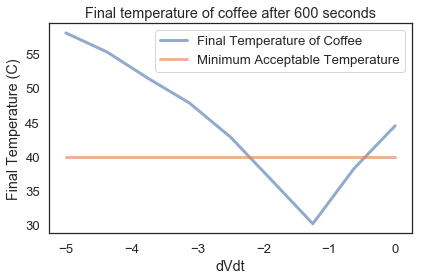

In [16]:
# Creating the time series in which the last temperatures from each dVdt sweep will be stored.
last_temp2 = TimeSeries()

def determine_last_temp(last_temp, system, swept2):
    # Selecting the last values from each sweep by selecting the temperature associated with the point 
    # at which the volume first hits 0 mL. If the volume never reaches 0, the last temperature is still selected. 
    for i in range(system.n_sweep):
        for t in range(system.t_end):
            if (swept2[i].V[t] == 0 or t == system.t_end - 1):
                last_temp[i] = swept2[i].T[t-1]
                break
    return last_temp

last_temp = determine_last_temp(last_temp2, system, swept2)

# To plot the data against dVdt and not against the sweep numbers, the dvdt values and last temperature
# values will be converted into lists and then plotted against each other.
dvdt_list2 = []
last_temp_list2 = []

for i in range(len(dvdt_range)):
    dvdt_list2.append(dvdt_range[i])
    last_temp_list2.append(last_temp2[i])

def plot_final_temp_and_minimum_acceptable_temp2(dvdt_list, last_temp_list2, minimum_acceptable_temp_list):
    plot(dvdt_list, last_temp_list2, label = 'Final Temperature of Coffee')
    
    # The minimum acceptable temperature will be plotted as a line. To achieve this, a list of length 
    # len(dvdt_range) will created and contain the minimum acceptable temperature in each index. 
    minimum_acceptable_temp_list = list()
    for i in range(len(dvdt_range)):
        minimum_acceptable_temp_list.append(minimum_acceptable_temp)
    plot(dvdt_list, minimum_acceptable_temp_list, label = 'Minimum Acceptable Temperature')
    return minimum_acceptable_temp_list

plot_final_temp_and_minimum_acceptable_temp2 = plot_final_temp_and_minimum_acceptable_temp2(dvdt_list, last_temp_list2, 
                                                                                          minimum_acceptable_temp)
decorate(xlabel = 'dVdt', 
         ylabel = 'Final Temperature (C)', 
         title = 'Final temperature of coffee after {} seconds'.format(system.t_end))

# Interpretation

The modeling of both empirical and mathematically derived data comes to a similar conclusion. Depending on how slow one is willing to drink their coffee, there are rates of coffee consumption that will ensure the final sip is still an enjoyable temperature. As our model goes for 10 minutes and defines the minimum enjoyable temperature to be 40°C, we found that at the end of this time frame, only intermediate rates of consumption fell below the minimum temperature. 

It is clear that the mathematical model and empirically defined model do not match up perfectly. There were many assumptions made in the process of creating our model. Significantly, we ignored internal convection and the heat transfer through the walls of the container that holds the coffee. If this work were to be continued, further steps would need to be taken in terms of an accurate representation of heat flow.

A relationship of note was that among the curves shown in the model, there is a point of inflection where `dvdt` must create a linear cooling line. Further expansion of this model would look into this relationship, finding where cooling could be completely linear.


# Abstract

The questions this model attempts to answer are, for a vessel of water: 
1. How can the relationship between the water's change in volume and change in rate of temperature change be qualitatively explained?
2. Can the temperature of water be predicted given parameters such as its rate of volume change, information about its container, etc.?
When the model invokes a mathematical representation of the r (a number that acts as a coefficient in Newton's Law of cooling) as a function of volume, and the simulation is run for 600 seconds, the final temperature of the water can be predicted as a function of the rate of change of volume over the 600 seconds:

In [19]:
plot_final_temp_and_minimum_acceptable_temp = plot_final_temp_and_minimum_acceptable_temp(dvdt_list, last_temp_list, 
                                                                                          minimum_acceptable_temp)

TypeError: 'list' object is not callable